# Random Graph Models

In this notebook we are going to explore and compare several random graph generation models. Two things:

- We first compare the performance of "hot neworks" (described in [*Willinger, Walter, David Alderson, and John C. Doyle. "Mathematics and the internet: A source of enormous confusion and great potential." Notices of the American Mathematical Society 56.5 (2009): 586-599.*](https://www.ams.org/notices/200905/rtx090500586p.pdf)) and the Barabasi-Albert models. What do we mean by "performance" here? Performance in this case means the ability to carry traffic flow in the networks, much like the [max flow problem](https://en.wikipedia.org/wiki/Maximum_flow_problem).
- We then show that why the Barabasi-Albert and the Watts-Strogatz models (and others) are better choices than the Erdos-Renyi Model.


## Task 1: Hot Networks

In this task you are given a core network inspired by an actual infrastructure and you are supposed to connect random nodes to the nodes of this core network according to a power law. Then you are supposed to calculate a performance measure for this network. 

Then, you are supposed to create a preferential attachment random graph based on the Barabasi-Albert model with the same number of nodes and compare the perfomance measure of this network to the first network. 

In [12]:
# Import libraries

import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("/home/zhliang/.local/lib/python3.7/site-packages")
import cvxpy as cp

import math
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

from functools import reduce

import pickle

### Step 1

Create the following graph in NetworkX.

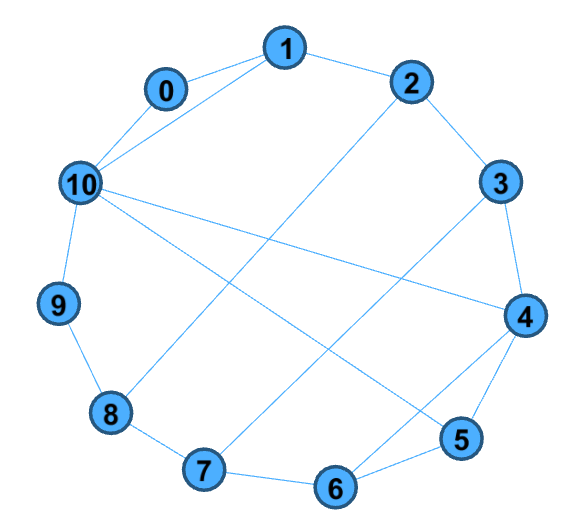

In [59]:
g = nx.cycle_graph(11)
# pos = nx.circular_layout(g)

g.add_edge(1, 10)
g.add_edge(4, 10)
g.add_edge(5, 10)
g.add_edge(2, 8)
g.add_edge(3, 7)
g.add_edge(4, 6)

# nx.draw_networkx(g, pos)
# plt.show()

### Step 2

To each node of the above core network connect a random number of new nodes according to a power law distribution with mean 10 and $\alpha = 3$.

In [60]:
edges_to_add = []
new_node_idx = g.order()

for node in g.nodes():
    num_new_nodes = nx.utils.zipf_rv(alpha=3, xmin=5)
    for new_node in range(new_node_idx, new_node_idx + num_new_nodes):
        edges_to_add.append((node, new_node))
    new_node_idx += num_new_nodes

for edge in edges_to_add:
    g.add_edge(*edge)

### Step 3

For each pair of the newly added nodes perform shortest-path routing using NetworkX and create a binary matrix $R$ such that each row of the matrix correspond to a core node and each column correspond to an ordered pair of newly added nodes. Each element of this matrix is "one" if the shortest path between the corresponding pair goes through the corresponding core node and "zero" otherwise. This matrix is sometimes called the routing matrix.

In [61]:
# Map pairs of (source, target) to an index in the matrix R
pair_to_idx = {}
idx = 0

for u in range(11, g.order()):
    for v in range(u + 1, g.order()):
        pair_to_idx[(u, v)] = idx
        idx += 1
        
# Now compute the shortest paths and update R

R = np.zeros((11, len(pair_to_idx)))
for pair in pair_to_idx:
    source, target = pair
    path = nx.shortest_path(g, source, target)
    for node in path:
        if node != source and node != target:
            R[node, pair_to_idx[pair]] = 1

### Step 4

Find the solution to the following linear programming using the `cvxpy` library:

$$ \max \sum X_{i,j} $$

$$ s.t. \ \ X_{i,j} \ge 0 , RX\le B  $$

Here, $B$ is a vector containing the maximum bandwidth of each of the core nodes. In this homework assume that all the elements of this vector are set to 10.

Noted by the instructor (Rohit Parasnis):

> Consider a subnetwork of the internet. $X_{i, j}$ is the amount of data transported per unit time from node $i$ to node $j$. For a core node $k$ and a pair $(i,j)$ of user nodes, the entry of $R$ corresponding to row $k$ and column $(i, j)$ (which I denote by $R_{k(i,j)}$ is 1 if and only if the shortest path from node i to node j passes through the core node $k$. So the $k$'th entry of $RX$ which is given by $\sum_{(i,j)} R_{k(i,j)} X_{i,j}$ is the total flow through the node $k$. This is upper bounded by the capacity of the node which is given by $B_k$. When you do this for all $k$, you get $RX \le B$. Subject to this constraint, you need to maximize the total flow through the node pairs.

> $X$ is a **column vector** with its length being the number of node pairs.

In [62]:
B = np.ones(11) * 10.0  # Bandwidth (capacity) vector
X = cp.Variable(len(pair_to_idx))  # Optimization variables

obj_function = cp.Maximize(cp.sum(X))
constraints = [0 <= X, cp.matmul(R, X) <= B]
problem = cp.Problem(obj_function, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = problem.solve()
print('Optimal objective value:\n', result, '\n')

# Optimal X
optimal_X = np.around(X.value, decimals=3) + 0
print('Optimal X:\n', optimal_X)

Optimal objective value:
 110.00000000000227 

Optimal X:
 [1.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    1.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    

The optimal objective value is around $110$.

### Step 5

Now create a Barabasi-Albert random graph with the same number of nodes as the previous graph and $m=1$ and visualize it using Gephi.

In [67]:
g2 = nx.barabasi_albert_graph(n=g.order(), m=1)
nx.write_gml(g2, 'g2.gml')

Visulization using Gephi:

<img src='g2-1.png' width=400 hight=400 />

### Step 6

Calculate the routing matrix for this random graph with the first 11 nodes as the core.

**Note:** Ignore the pairs whose shortest path does not go through the core. This will ensure the solution is bounded.

In [68]:
# Map pairs of (source, target) to an index in the matrix R2
pair_to_idx2 = {}
idx = 0

for u in range(11, g2.order()):
    for v in range(u + 1, g2.order()):
        path = nx.shortest_path(g2, u, v)
        is_through_core = reduce(lambda x, y: x or y, map(lambda x: x < 11, path))
        
        if is_through_core:  # Ignore the pairs whose shortest path does not go through the core.
            pair_to_idx2[(u, v)] = idx
            idx += 1
        
# Now compute the shortest paths and update R2
R2 = np.zeros((11, len(pair_to_idx2)))
for pair in pair_to_idx2:
    source, target = pair
    path = nx.shortest_path(g2, source, target)
    for node in path:
        if node < 11:  # Must be in the core network
            R2[node, pair_to_idx2[pair]] = 1

### Step 7

Now solve the previous optimization problem for this random graph and compare the result with the previous result. Which network has a higher performance and why?

In [69]:
X2 = cp.Variable(len(pair_to_idx2))  # Optimization variables

obj_function2 = cp.Maximize(cp.sum(X2))
constraints2 = [0 <= X2, cp.matmul(R2, X2) <= B]
problem2 = cp.Problem(obj_function2, constraints2)

# The optimal objective value is returned by `prob.solve()`.
result2 = problem2.solve()
print('Optimal objective value:\n', result2, '\n')

# Optimal X
optimal_X2 = np.around(X2.value, decimals=3) + 0
print('Optimal X:\n', optimal_X2)

Optimal objective value:
 89.99999999999984 

Optimal X:
 [0.556 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.556 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.556 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.556 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.556 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.556 0.    0.    0.    0.    0.556 0.
 0.    0.    0.    0.    0.    0

The optimal objective value is around $90$.

**Comparision of HOTnet and BA model:** The first network (HOTnet) has higher performance.

**Reasons:** (1) The high-degree, core nodes in the scale-free network generated by Barabasi-Albert algorithm get saturated and, as a result, create bottlenecks, leaving the rest of the network with low overall utilization. (2) In the first network (HOTnet), the average number of newly added nodes, i.e. 10, is set to the maximum bandwidth of the core nodes. This design decision effectively prevents bottlenecks, thereby increasing the overall network throughput.

**Reference:** Doyle, John C., et al. "The “robust yet fragile” nature of the Internet." Proceedings of the National Academy of Sciences 102.41 (2005): 14497-14502.

## Task 2: More on the Barabasi-Albert Model

In the previous task, you evaluated the abilities of Barabasi-Albert networks to transfer data from one node to another. In this task, you will explore these networks further.

### Step 1

Using NetworkX, generate four Barabasi-Albert Random Graphs (BARGs) with `n = 1000, 10000` nodes and with parameters `m = 2, 5`.

In [52]:
bag1000_2 = nx.barabasi_albert_graph(n=1000, m=2)
bag1000_5 = nx.barabasi_albert_graph(n=1000, m=5)
bag10000_2 = nx.barabasi_albert_graph(n=10000, m=2)
bag10000_5 = nx.barabasi_albert_graph(n=10000, m=5)

### Step 2

Use NetworkX to store the graphs in `.gml` and then visualize them using Gephi such that (1) each node has a size proportional to its degree and (2) its color is also related to its degree. Include your visualizations in this notebook. Do you see an interesting property for these graphs? Explain your answer.

In [53]:
nx.write_gml(bag1000_2, 'bag1000_2.gml')
nx.write_gml(bag1000_5, 'bag1000_5.gml')
nx.write_gml(bag10000_2, 'bag10000_2.gml')
nx.write_gml(bag10000_5, 'bag10000_5.gml')

####  n = 1000, m = 2

<img src='bag1000_2.png' width=400 height=400>

####  n = 1000, m = 5

<img src='bag1000_5.png' width=400 height=400>

####  n = 10000, m = 2

<img src='bag10000_2.png' width=400 height=400>

####  n = 10000, m = 5

<img src='bag10000_5.png' width=400 height=400>

#### Observation

- $n$ being equal, larger $m$ leads to more edges and more core nodes (i.e. nodes with high degree).
- $m$ being equal, larger $n$ leads to fewer yet more dominant core nodes.

#### Explanation

Relatively lower values of $m$ (that is, $m = 2$ when $n$ being equal, or $n = 10000$ when $m$ being equal) reinforce the dominance of nodes with high degree This is sometimes called the **Matthew effect**, or "the rich get richer".

### Step 3

Calculate the diamater and the average shortest path lengths of these graphs. Also plot the (local) clustering coefficient of the nodes of these graphs. 

In [39]:
def show_properties(graph, pickle_name):
    if nx.is_connected(graph):
        diameter = nx.diameter(graph)
        aspl = nx.average_shortest_path_length(graph)
    else:
        diameter = float('inf')
        aspl = float('inf')
    
    print('Diameter:', diameter)
    print('Average shortest path lengths:', aspl)

    cc = nx.clustering(graph)
    with open(pickle_name, 'wb') as f:
        pickle.dump(cc, f)
        
def plot_cc(pickle_name, bins=1000, log=False):
    with open(pickle_name, 'rb') as f:
        cc = pickle.load(f)
    
    cc_list = list(cc.values())
    xlim = [0, max(cc_list)]
    
    plt.hist(cc_list, bins=bins, log=log)
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('# Nodes')
    plt.xlim(xlim)
    print("Average clusterng coefficient:", np.mean(list(cc.values())))    

#### n = 1000, m = 2

Diameter: 7
Average shortest path lengths: 3.9841821821821823
Average clusterng coefficient: 0.035590905299811126


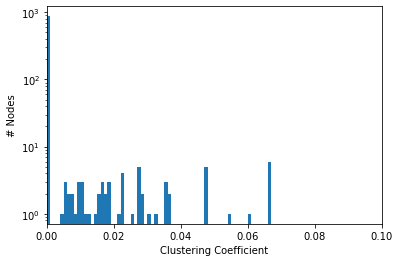

In [99]:
show_properties(bag1000_2, 'bag1000_2_cc.pickle')
plot_cc('bag1000_2_cc.pickle', xrlim=0.1, bins=1000)

#### n = 1000, m = 5

Diameter: 5
Average shortest path lengths: 2.990782782782783
Average clusterng coefficient: 0.03672882088985557


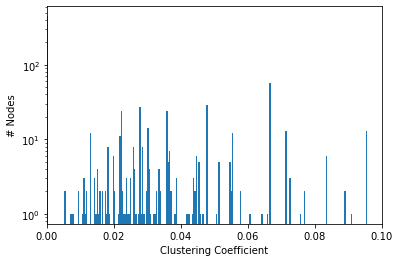

In [109]:
show_properties(bag1000_5, 'bag1000_5_cc.pickle')
plot_cc('bag1000_5_cc.pickle', xrlim=0.1, bins=100)

#### n = 10000, m = 2

Diameter: 9
Average shortest path lengths: 5.010784098409841
Average clusterng coefficient: 0.0036147750430557037


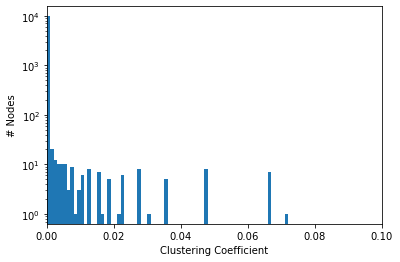

In [81]:
show_properties(bag10000_2, 'bag10000_2_cc.pickle')
plot_cc('bag10000_2_cc.pickle', xrlim=0.1, bins=1000)

#### n = 10000, m = 5

Diameter: 6
Average shortest path lengths: 3.657444904490449
Average clusterng coefficient: 0.006919423375450445


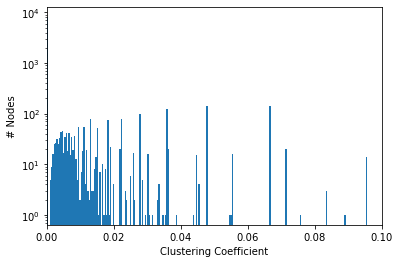

In [82]:
show_properties(bag10000_5, 'bag10000_5_cc.pickle')
plot_cc('bag10000_5_cc.pickle', xrlim=0.1, bins=1000)

## Task 3: Another Candidate Model for Describing Social Networks

As you know, the Watts-Strogatz generative model was proposed in 1998 in order to address certain limitation(s) of Erdos-Renyi random graphs in the context of modeling real-world social networks. In this task and the next, you will examine the properties of Watts-Strogatz networks and compare them with those of Barabasi-Albert networks (one of whose objectives is to model social networks) as well as ER random graphs. 

### Step 1

Using NetworkX generate three Watts-Strogatz Random Graphs (WSRGs) with n = 1000 nodes and with parameters k = 5, and p = 0.2, 0.5, and 0.8.

In [84]:
wsg_02 = nx.connected_watts_strogatz_graph(n=1000, k=5, p=0.2)
wsg_05 = nx.connected_watts_strogatz_graph(n=1000, k=5, p=0.5)
wsg_08 = nx.connected_watts_strogatz_graph(n=1000, k=5, p=0.8)

### Step 2

Use NetworkX to store the graphs in `.gml` and then visualize them using Gephi. Include your visualizations in this notebook.

In [85]:
nx.write_gml(wsg_02, 'wsg_02.gml')
nx.write_gml(wsg_05, 'wsg_05.gml')
nx.write_gml(wsg_08, 'wsg_08.gml')

#### p = 0.2

<img src='wsg_02.png' width=400 height=400>

#### p = 0.5

<img src='wsg_05.png' width=400 height=400>

#### p = 0.8

<img src='wsg_08.png' width=400 height=400>


### Step 3

Plot the degree distibution of these graphs in arithmetic and log-log scale figures. Based on the plots, do you think Watts-Strogatz networks follow a power-law degree distribution? Why or why not?

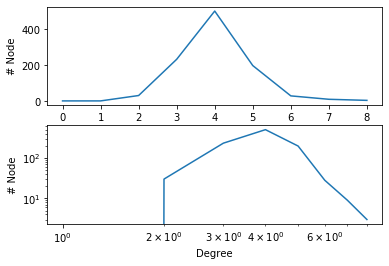

In [86]:
# p = 0.2
plt.subplot(211)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.plot(nx.degree_histogram(wsg_02))

plt.subplot(212)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.loglog(nx.degree_histogram(wsg_02))

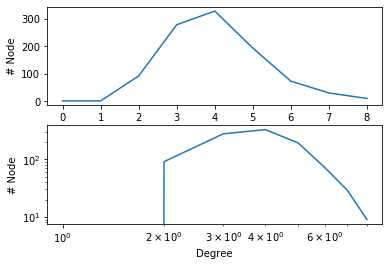

In [87]:
# p = 0.5
plt.subplot(211)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.plot(nx.degree_histogram(wsg_05))

plt.subplot(212)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.loglog(nx.degree_histogram(wsg_05))

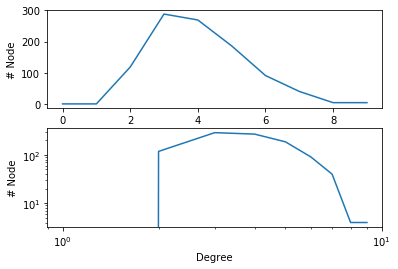

In [91]:
# p = 0.8
plt.subplot(211)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.plot(nx.degree_histogram(wsg_08))

plt.subplot(212)
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.loglog(nx.degree_histogram(wsg_08))

**Observation:** They don't seem to follow power-law degree distributions.

**Reason:** The shape of the degree distribution is similar to that of a random graph and has a peak at around $\text{degree} = 5$ and decays exponentially for large degrees. Almost all nodes are of similar degree.

### Step 4

Calculate the diamaters and the average shortest path lengths of these graphs. Also plot the clustering coefficients of the nodes of these graphs. Compare these results with the ones you obtained for the Barabasi-Albert model. Based on this comparison, which of the two models is a better choice for describing online social networks in your opinion? Explain your answer.

#### p = 0.2

Diameter: 12
Average shortest path lengths: 6.8072632632632635
Average clusterng coefficient: 0.2515904761904762


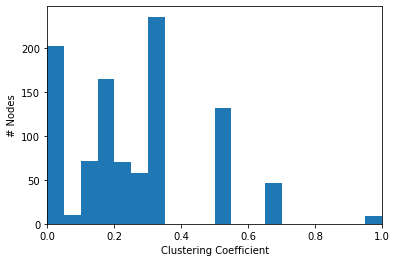

In [90]:
show_properties(wsg_02, 'wsg02_cc.pickle')
plot_cc('wsg02_cc.pickle', bins=20)

#### p = 0.5

Diameter: 10
Average shortest path lengths: 5.592188188188188
Average clusterng coefficient: 0.0727


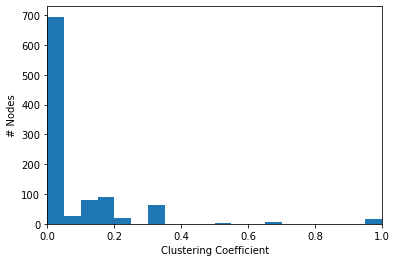

In [91]:
show_properties(wsg_05, 'wsg05_cc.pickle')
plot_cc('wsg05_cc.pickle', bins=20)

#### p = 0.8

Diameter: 9
Average shortest path lengths: 5.329825825825826
Average clusterng coefficient: 0.007822222222222222


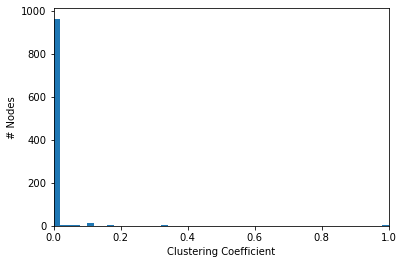

In [93]:
show_properties(wsg_08, 'wsg08_cc.pickle')
plot_cc('wsg08_cc.pickle', bins=50)

#### Comparison with Barabasi-Albert model

- Graphs generated by the Barabasi-Albert model have smaller diameter and avaerage shortest path length.
- Graphs generated by the Watts-Strogatz have much higher average clustering coefficient than that by the Barabasi-Albert model when $p$ is small. As $p$ becomes larger, however, the average clustering coefficient decreases rapidly.

#### Which one is a better choice for describing online social networks? Why?

The Watts-Strogatz model has small world characteristics (i.e. high clustering and low path lengths), but the degree distribution is roughly normal, which is very different from real online social networks.

The Barabasi-Albert model has low shortest path lengths and scale-free characteristics (i.e. a heavy-tailed degree distribution), but it has low clustering.

We assume that the social network in question is "*introverted*", meaning that it doesn't allow public following as in Twitter. Instead, we assume a Facebook-like social network in which people become friends by sending requests. Then the Watts-Strogatz model better describes our source network because of degree distribution.

**Conclusion: The Watts-Strogatz model is a better choice for describing online social networks.**

### Step 5

Now, consider a network that describes the hierarchical structure of an organization, i.e., a network that captures the hierarchical connections between the employees of the organization. It is a network in which two employees are connected by an edge if and only if one of them is the immediate supervisor/boss of the other. Do you think either of the two models that you have examined so far is suitable for describing such a hierarchical network? Why or why not? You may assume that if an employee has two or more immediate supervisors, then all of these supervisors are located at the same level in the hierarchy of the organization.

**Short answer:** No.
    
**Reasons:**

1. Such hierarchical structure is basically a **directed acyclic graph (DAG)**. Since we assume all supervisors of a given employee are at the same level, the diameter of this DAG is the length of the longest path between any two nodes in the DAG, which is about twice the height of the hierarchy, which in turn can be substantially large (e.g. ~20) for some organizations.
2. Such hierarchical structure by no means implys the presence of **clustering**.
3. Typically, a well-structured orginazation should make each employ have relatively the **same node degree**, which resembles none of the two models.

## Task 4 (Bonus Task): Do the above models outperform ER Random Graphs?

### Step 1

Using NetworkX, generate six Erdos-Renyi Random Graphs (ERRGs) with $n = 1000$ nodes and with parameters p = $\frac{0.5}{n}$, $\frac{1}{n}$, $\frac{1.5}{n}$, $\frac{0.5 \ln(n)}{n}$, $\frac{\ln(n)}{n}$, $\frac{1.5 \ln(n)}{n}$.

In [70]:
n = 1000

errg1 = nx.erdos_renyi_graph(n, 0.5 / n)
errg2 = nx.erdos_renyi_graph(n, 1.0 / n)
errg3 = nx.erdos_renyi_graph(n, 1.5 / n)
errg4 = nx.erdos_renyi_graph(n, 0.5 * math.log(n) / n)
errg5 = nx.erdos_renyi_graph(n, math.log(n) / n)
errg6 = nx.erdos_renyi_graph(n, 1.5 * math.log(n) /n)

### Step 2

Calculate the diamaters and the average shortest path lengths of these graphs. Also plot the clustering coefficients of the nodes of these graphs. Compare these results with the ones you obtained for the previous models. Based on your comparison, do you think that the Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for describing online social networks? Explain your answer.

#### p = $\frac{0.5}{n}$

Note that the graph is not connected.

Diameter: inf
Average shortest path lengths: inf
Average clusterng coefficient: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


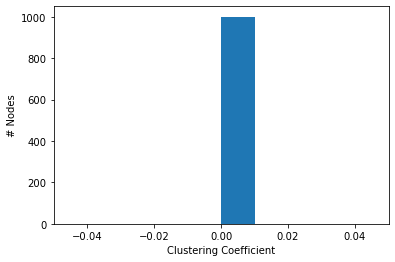

In [73]:
show_properties(errg1, 'errg1_cc.pickle') 
plot_cc('errg1_cc.pickle', bins=100, log=False)

#### p = $\frac{1}{n}$

The graph is still not connected.

Diameter: inf
Average shortest path lengths: inf
Average clusterng coefficient: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


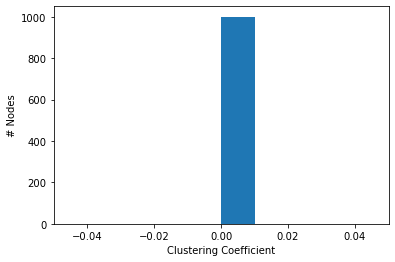

In [75]:
show_properties(errg2, 'errg2_cc.pickle')
plot_cc('errg2_cc.pickle', bins=100, log=False)

#### p = $\frac{1.5}{n}$

The graph is not connected.

Diameter: inf
Average shortest path lengths: inf
Average clusterng coefficient: 0.001


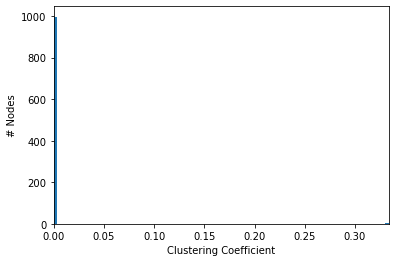

In [77]:
show_properties(errg3, 'errg3_cc.pickle')
plot_cc('errg3_cc.pickle', bins=100, log=False)

#### p = $\frac{0.5 \ln(n)}{n}$

Still not connected.

Diameter: inf
Average shortest path lengths: inf
Average clusterng coefficient: 0.0006333333333333333


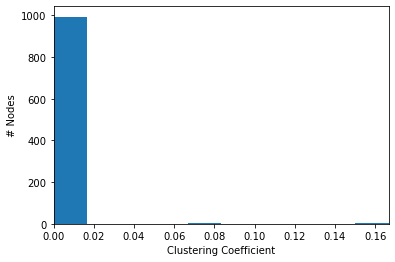

In [83]:
show_properties(errg4, 'errg4_cc.pickle')
plot_cc('errg4_cc.pickle', bins=10, log=False)

#### p = $\frac{\ln(n)}{n}$

Diameter: inf
Average shortest path lengths: inf
Average clusterng coefficient: 0.0069924381174381175


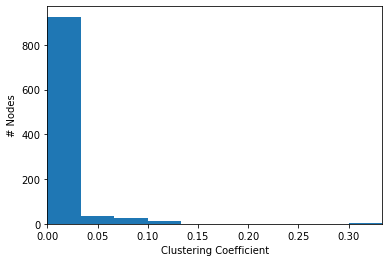

In [82]:
show_properties(errg5, 'errg5_cc.pickle')
plot_cc('errg5_cc.pickle', bins=10, log=False)

#### p = $\frac{1.5 \ln(n)}{n}$

Diameter: 5
Average shortest path lengths: 3.1992692692692692
Average clusterng coefficient: 0.011630811362699906


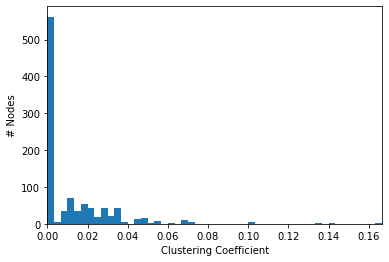

In [42]:
show_properties(errg6, 'errg6_cc.pickle')
plot_cc('errg6_cc.pickle', bins=50)

#### Compare these results with the ones you obtained for the previous models.

1. For ER model to generate a connected graph we need a sufficiently large $p$. In fact, a graph in $G(n, p)$ will almost surely be connected if $p > \frac{(1 + \epsilon) \ln n}{n}$ where $\epsilon > 0$. However, unusually large $p$ is not common in real world social networks.
2. Graphs generated by the ER model have much lower average clustering coefficient than that by Watts-Strogatz model with a small $p$.
3. As the $p$ Watts-Strogatz model increases, the generated graphs become more and more similar to random graphs generated by ER model in terms of degree distribution. This inplies that large $p$ in Watts-Strogatz model can make the model unrealistic.

#### Based on your comparison, do you think that the Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for describing online social networks? Explain your answer.

**Answer:** Yes. Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for this purpose.

**Explanation:** 
- This is because social networks are generally characterized by (1) small average distance (i.e. graph diameter), (2) large clustering coefficient, (3) giant connected component, and maybe (4) power law distribution. 
- The Barabasi-Albert model generates graphs the satisfy (1), (3), and (4). The Watts-Strogatz models generate graphs that satisfy (1), (2), and (3). However, the ER model satisfies none of the above characteristics unless an unrealisticallu large $p$ is used, and even so (1) and (4) may still not be satisfied.
- We thus conclude that Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model.